# Simulation - Projet

## Importation des modules nécessaires


In [105]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math

## Lecture du fichier d'entrée

In [106]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


## Compter effectif

In [107]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les valeurs apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les valeurs apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


## Construire histogramme


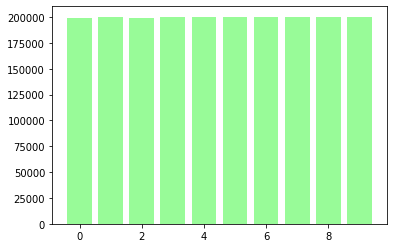

In [108]:
def construct_hist(labels, counts):
    fig, ax = plt.subplots()
    ax.bar(labels, counts, color='palegreen')
    plt.show()

construct_hist(e_labels, e_counts)

## Test du Chi-Carré

In [109]:
def chi_squared_uniform(counts):
    pi = 1 / len(counts)
    N = sum(counts)
    kr = np.sum(((counts-(N*pi))/(math.sqrt(N*pi)))**2)
    critical = stat.chi2.ppf(q=0.95, df=9)
    return kr <= critical, kr, critical

print(f'Le résultat de notre test du Chi-Carré est : \n {chi_squared_uniform(e_counts)}')

Le résultat de notre test du Chi-Carré est : 
 (True, 8.65376, 16.918977604620448)


## Test de Kolmogorov-Smirnov

In [110]:
def kolmogorov_smirnov(labels, counts):
    assert len(labels) == len(counts)
    pi = 1 / len(counts)
    N = np.sum(counts)
    real_repartition = np.cumsum(counts, axis=0)/N
    th_repartition = np.cumsum(np.ones(len(labels))*pi)
    maximum = np.max(np.abs(real_repartition-th_repartition))
    critical = 1.358/math.sqrt(N/len(labels))
    return maximum < critical, maximum, critical

print(kolmogorov_smirnov(e_labels, e_counts))

(True, 0.0006325000000000358, 0.0030365803134447147)


## Test du Poker

In [111]:
def poker_test(data, labels, counts):
    number_lists = len(data)/4
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        vals, cts = np.unique(li, return_counts=True)
        if len(cts) == 4:
            all_diff += 1
        elif len(cts) == 3:
            one_pair += 1
        elif len(cts) == 2:
            if 3 in cts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    return chi_squarred_poker(np.array([all_diff, one_pair, triplet, two_pair, quadr]), len(lists))

def chi_squarred_poker(observed, N):    # P(all_diff) > P(one_pair) > P(triplet) > P(two_pair) > P(quadr)
    probas = np.array([0.5, 0.425, 0.035, 0.025, 0.001])
    theorical = probas * N
    kr = np.sum(((observed-theorical)**2)/theorical)
    critical = stat.chi2.ppf(q=0.95, df=4)
    return kr <= critical, kr, critical

print(f'Test du Poker {poker_test(e_numbers, e_labels, e_counts)}')

Test du Poker (False, 163.24725899159665, 9.487729036781154)


## Test du gap

In [117]:
def gap_test(data, a: int = 0, b: int = 5, total_numbers: int = 10):
    assert a < b
    probability = (b - a) / total_numbers  # => proba 1/2 d'être marqué
    intervals = []
    length_series_not_in = 0
    total = 0
    sequence_length = 0
    for nb in data:
        if a <= nb < b:
            # nb in interval, with probability `probability`
            intervals.append(length_series_not_in)
            length_series_not_in = 1
        else:
            # nb not in interval
            length_series_not_in += 1
            total += 1
        sequence_length += 1
    labels, observed = np.unique(np.array(intervals), return_counts=True)
    observed = np.cumsum(complete_labels(labels, observed)/sequence_length)
    theorical = np.cumsum(np.array([probability ** (n + 1) for n in range(max(labels))]))
    kr = sum(((observed - theorical) ** 2) / theorical)
    crit = stat.chi2.ppf(q=0.05, df=len(observed) - 1)
    return kr <= crit, kr, crit

def complete_labels(labels, observed):
    i = 1
    j = 0
    n = 1
    res = []
    while j < len(labels):
        label = labels[j]
        if i != label:
            res.append(0)
            n += 1
        else:
            res.append(observed[i-n])
            j += 1
        i += 1
    return np.array(res)

gap_test(e_numbers)

(True, 5.5117785465143285, 12.338014578790643)

## Generateur

In [122]:
def generator(n: int = 1):
    for i in range(n):
        seed = e_numbers[i]
        a = len(e_numbers) - seed
        c = e_numbers[i + seed]
        x = (a * seed + c) % 10
        a = len(e_numbers) - x
        c = e_numbers[i + x]
        y = (a * seed + c) % 10
        a = len(e_numbers) - y
        c = e_numbers[i + y]
        z = (a * seed + c) % 10
        res = math.sqrt(x ** 2 + y ** 2 + z ** 2)
        while res > 1:
            res = res/10
        yield res

list(generator(1000))

[0.5099019513592784,
 0.99498743710662,
 0.7280109889280518,
 0.9273618495495703,
 0.9695359714832659,
 0.9110433579144299,
 0.5099019513592784,
 0.2,
 0.10723805294763608,
 0.11704699910719625,
 0.8602325267042626,
 0.15588457268119896,
 0.0,
 0.10049875621120889,
 0.99498743710662,
 0.17320508075688773,
 0.9219544457292888,
 0.6557438524302001,
 0.5196152422706632,
 0.5099019513592784,
 0.0,
 0.1044030650891055,
 0.8485281374238569,
 0.12124355652982141,
 0.12041594578792296,
 0.6403124237432849,
 0.9695359714832659,
 0.11045361017187261,
 0.10295630140987,
 0.34641016151377546,
 0.6082762530298219,
 0.10816653826391968,
 0.8660254037844387,
 0.13341664064126335,
 0.13856406460551018,
 0.7071067811865476,
 0.7,
 0.8660254037844387,
 0.12124355652982141,
 0.5099019513592784,
 0.7681145747868607,
 0.7,
 0.0,
 0.7280109889280518,
 0.3,
 0.13674794331177345,
 0.10295630140987,
 0.8831760866327848,
 0.9,
 0.6928203230275509,
 0.11000000000000001,
 0.458257569495584,
 0.10630145812734651,
